In [46]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import os
from skimage.transform import resize
from tqdm import tqdm_notebook

from keras.preprocessing.image import ImageDataGenerator, NumpyArrayIterator, array_to_img
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam

In [4]:
train_df = pd.read_csv('datasets/train.csv')
train_id = train_df.pop('id')
    
train_y = train_df.pop('species')
species_encoder = preprocessing.LabelEncoder().fit(train_y)
train_y = species_encoder.transform(train_y)

numerical_scaler = preprocessing.StandardScaler().fit(train_df)
train_numerical = numerical_scaler.transform(train_df)

In [6]:
path = 'datasets/images/images'
train_img = []
test_img = []
# train_img_id = []
# test_img_id = []
desired_size = (96, 96)
img_names = os.listdir(path)
img_names.sort(key=lambda x:int(x.split('.')[0]))

for img_name in tqdm_notebook(img_names):
    img = cv2.imread(path+'/'+img_name, 0)
    height, width = img.shape
    if height < width:
        delta_size = width - height
        img = cv2.copyMakeBorder(img, delta_size//2, delta_size//2, 
                                    0, 0, cv2.BORDER_CONSTANT, value=[0])
    elif height > width:
        delta_size = height - width
        img = cv2.copyMakeBorder(img, 0, 0, delta_size//2, delta_size//2,
                                    cv2.BORDER_CONSTANT, value=[0])
    img = resize(img, desired_size, mode='constant', preserve_range=True)
    img = img/255.

    img_name = int(img_name.split('.')[0])
    if img_name in np.array(train_id):
        train_img.append(img)
#         train_img_id.append(img_name)
    else:
        test_img.append(img)
#         test_img_id.append(img_name)
    
# list_img = np.array(list_img)
# list_img_id = np.array(list_img_id).astype(int)

In [7]:
train_img = np.array(train_img)
train_img = np.expand_dims(train_img, axis=-1)
test_img = np.array(test_img)
test_img = np.expand_dims(test_img, axis=-1)

train_y = to_categorical(train_y)
# train_img_id = np.array(train_img_id)
# test_img_id = np.array(test_img_id)

In [8]:
train_img, val_img, train_numerical, val_numerical, train_y, val_y = train_test_split(train_img, train_numerical, train_y,
                                                                                     test_size=0.2)

In [11]:
# seed = 123
batch_size = 32

data_gen_args = dict(rotation_range=20,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='nearest')

train_datagen = ImageDataGenerator(**data_gen_args)
val_datagen = ImageDataGenerator(**data_gen_args)

# train_generator = train_datagen.flow(train_img, train_y, batch_size=batch_size,
#                                     seed=seed)
# val_generator = val_datagen.flow(val_img, val_y, batch_size=batch_size,
#                                 seed=seed)

In [12]:
# def combined_generator(imgen, numerical_input):
#     while True:
#         for i in range(numerical_input.shape[0]):
#             batch_img, batch_y = next(imgen)
#             numerical_X = numerical_input[imgen.index_array]
#             yield [batch_img, numerical_X], batch_y

In [13]:
def combined_generator(imgen, image_input, numerical_input, y):
    batch_size = 32
    seed = np.random.randint(1, 1000)
    genX1 = imgen.flow(image_input, y, batch_size=batch_size, seed=seed)
    genX2 = imgen.flow(image_input, numerical_input, batch_size=batch_size, seed=seed)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        
        yield [X1i[0], X2i[1]], X1i[1]

In [14]:
train_generator = combined_generator(train_datagen, train_img, train_numerical, train_y)
val_generator = combined_generator(val_datagen, val_img, val_numerical, val_y)

In [17]:
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, concatenate
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [56]:
def get_model():
    image_input = Input((96, 96, 1), name='image')
        
    X = Conv2D(16, (3, 3), padding='same')(image_input)
    X = BatchNormalization()(X)
    X = MaxPooling2D((2, 2))(X)
    
    X = Conv2D(32, (3, 3), padding='same')(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D((2, 2))(X)
    
    X = Conv2D(64, (3, 3), padding='same')(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D((2, 2))(X)
    
    X = Conv2D(128, (3, 3), padding='same')(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D((2, 2))(X)
    
    X = Flatten()(X)
    X1 = Dense(512, activation='relu')(X)
    X1 = Dense(128, activation='relu')(X1)
    numerical_input = Input((192, ), name='numerical')
    X2 = Dense(128, activation='relu')(numerical_input)
    X = concatenate([X1, X2])
    X = Dense(128, activation='relu')(X)
    X = Dropout(0.5)(X)
    out = Dense(99, activation='softmax')(X)
    
    model = Model(inputs=[image_input, numerical_input], outputs=out)
    return model

In [62]:
model1 = get_model()
model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 96, 96, 16)   160         image[0][0]                      
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 96, 96, 16)   64          conv2d_18[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_18 (MaxPooling2D) (None, 48, 48, 16)   0           batch_normalization_18[0][0]     
__________________________________________________________________________________________________
conv2d_19 

In [63]:
# adam = Adam(lr=0.01)
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [64]:
early_stopping = EarlyStopping(patience=30, verbose=1)
model_checkpoint = ModelCheckpoint('NN_v5.model', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.0001, verbose=1)

In [65]:
train_history1 = model1.fit_generator(train_generator,
                                    steps_per_epoch=int(len(train_img)/32),
                                    validation_data=val_generator,
                                    validation_steps=int(len(val_img)/32),
                                    epochs=300,
                                    callbacks=[early_stopping, model_checkpoint, reduce_lr],
                                    verbose=1)

Epoch 1/300
24/24 [==============================] - ETA: 52s - loss: 5.4087 - acc: 0.0000e+ - ETA: 16s - loss: 5.3436 - acc: 0.0104   - ETA: 9s - loss: 5.1844 - acc: 0.0250 - ETA: 6s - loss: 5.1965 - acc: 0.022 - ETA: 4s - loss: 5.1086 - acc: 0.020 - ETA: 3s - loss: 5.0555 - acc: 0.017 - ETA: 2s - loss: 5.0164 - acc: 0.014 - ETA: 1s - loss: 4.9626 - acc: 0.014 - ETA: 1s - loss: 4.9133 - acc: 0.016 - ETA: 0s - loss: 4.8731 - acc: 0.023 - ETA: 0s - loss: 4.8328 - acc: 0.023 - ETA: 0s - loss: 4.7996 - acc: 0.023 - 3s 145ms/step - loss: 4.7788 - acc: 0.0234 - val_loss: 4.2375 - val_acc: 0.1024

Epoch 00001: val_loss improved from inf to 4.23751, saving model to NN_v5.model
Epoch 2/300
24/24 [==============================] - ETA: 0s - loss: 4.5871 - acc: 0.0000e+0 - ETA: 0s - loss: 4.3151 - acc: 0.0417    - ETA: 0s - loss: 4.2820 - acc: 0.050 - ETA: 0s - loss: 4.2924 - acc: 0.058 - ETA: 0s - loss: 4.2467 - acc: 0.069 - ETA: 0s - loss: 4.2371 - acc: 0.079 - ETA: 0s - loss: 4.2060 - acc: 0.

24/24 [==============================] - ETA: 0s - loss: 0.2426 - acc: 0.906 - ETA: 0s - loss: 0.1728 - acc: 0.968 - ETA: 0s - loss: 0.1838 - acc: 0.953 - ETA: 0s - loss: 0.1781 - acc: 0.950 - ETA: 1s - loss: 0.2046 - acc: 0.947 - ETA: 0s - loss: 0.2091 - acc: 0.947 - ETA: 0s - loss: 0.2035 - acc: 0.950 - ETA: 0s - loss: 0.2121 - acc: 0.949 - ETA: 0s - loss: 0.2112 - acc: 0.950 - ETA: 0s - loss: 0.2153 - acc: 0.949 - ETA: 0s - loss: 0.2161 - acc: 0.943 - ETA: 0s - loss: 0.2064 - acc: 0.947 - ETA: 0s - loss: 0.2180 - acc: 0.943 - ETA: 0s - loss: 0.2272 - acc: 0.938 - ETA: 0s - loss: 0.2248 - acc: 0.938 - ETA: 0s - loss: 0.2211 - acc: 0.938 - ETA: 0s - loss: 0.2196 - acc: 0.938 - ETA: 0s - loss: 0.2128 - acc: 0.941 - ETA: 0s - loss: 0.2171 - acc: 0.940 - ETA: 0s - loss: 0.2224 - acc: 0.937 - ETA: 0s - loss: 0.2223 - acc: 0.938 - 2s 64ms/step - loss: 0.2173 - acc: 0.9410 - val_loss: 0.1217 - val_acc: 0.9639

Epoch 00018: val_loss did not improve from 0.11439
Epoch 19/300
24/24 [==========

24/24 [==============================] - ETA: 0s - loss: 0.1693 - acc: 0.906 - ETA: 1s - loss: 0.0947 - acc: 0.953 - ETA: 1s - loss: 0.0690 - acc: 0.968 - ETA: 1s - loss: 0.0618 - acc: 0.976 - ETA: 1s - loss: 0.0675 - acc: 0.975 - ETA: 1s - loss: 0.0778 - acc: 0.974 - ETA: 1s - loss: 0.0706 - acc: 0.977 - ETA: 1s - loss: 0.0694 - acc: 0.976 - ETA: 1s - loss: 0.0641 - acc: 0.979 - ETA: 0s - loss: 0.0611 - acc: 0.981 - ETA: 0s - loss: 0.0595 - acc: 0.983 - ETA: 0s - loss: 0.0587 - acc: 0.984 - ETA: 0s - loss: 0.0565 - acc: 0.985 - ETA: 0s - loss: 0.0549 - acc: 0.986 - ETA: 0s - loss: 0.0539 - acc: 0.987 - ETA: 0s - loss: 0.0551 - acc: 0.986 - ETA: 0s - loss: 0.0556 - acc: 0.987 - ETA: 0s - loss: 0.0576 - acc: 0.984 - ETA: 0s - loss: 0.0569 - acc: 0.985 - ETA: 0s - loss: 0.0549 - acc: 0.985 - ETA: 0s - loss: 0.0546 - acc: 0.986 - ETA: 0s - loss: 0.0556 - acc: 0.985 - ETA: 0s - loss: 0.0548 - acc: 0.986 - 2s 75ms/step - loss: 0.0544 - acc: 0.9870 - val_loss: 0.0653 - val_acc: 0.9792

Epoch

24/24 [==============================] - ETA: 0s - loss: 0.0436 - acc: 1.000 - ETA: 1s - loss: 0.0276 - acc: 1.000 - ETA: 1s - loss: 0.0246 - acc: 1.000 - ETA: 1s - loss: 0.0237 - acc: 1.000 - ETA: 1s - loss: 0.0243 - acc: 1.000 - ETA: 1s - loss: 0.0230 - acc: 1.000 - ETA: 0s - loss: 0.0248 - acc: 1.000 - ETA: 0s - loss: 0.0232 - acc: 1.000 - ETA: 0s - loss: 0.0229 - acc: 1.000 - ETA: 0s - loss: 0.0264 - acc: 0.997 - ETA: 0s - loss: 0.0271 - acc: 0.997 - ETA: 0s - loss: 0.0281 - acc: 0.995 - ETA: 0s - loss: 0.0276 - acc: 0.995 - ETA: 0s - loss: 0.0284 - acc: 0.996 - ETA: 0s - loss: 0.0283 - acc: 0.996 - ETA: 0s - loss: 0.0300 - acc: 0.996 - ETA: 0s - loss: 0.0316 - acc: 0.995 - ETA: 0s - loss: 0.0305 - acc: 0.995 - ETA: 0s - loss: 0.0304 - acc: 0.995 - ETA: 0s - loss: 0.0296 - acc: 0.995 - ETA: 0s - loss: 0.0293 - acc: 0.995 - 1s 61ms/step - loss: 0.0291 - acc: 0.9961 - val_loss: 0.0381 - val_acc: 0.9940

Epoch 00050: val_loss did not improve from 0.03524

Epoch 00050: ReduceLROnPlatea

24/24 [==============================] - ETA: 0s - loss: 0.0583 - acc: 0.968 - ETA: 0s - loss: 0.0527 - acc: 0.968 - ETA: 0s - loss: 0.0379 - acc: 0.981 - ETA: 0s - loss: 0.0336 - acc: 0.984 - ETA: 0s - loss: 0.0322 - acc: 0.986 - ETA: 0s - loss: 0.0290 - acc: 0.988 - ETA: 0s - loss: 0.0282 - acc: 0.987 - ETA: 0s - loss: 0.0283 - acc: 0.988 - ETA: 0s - loss: 0.0270 - acc: 0.989 - ETA: 0s - loss: 0.0294 - acc: 0.990 - ETA: 0s - loss: 0.0279 - acc: 0.991 - ETA: 0s - loss: 0.0277 - acc: 0.991 - ETA: 0s - loss: 0.0292 - acc: 0.990 - ETA: 0s - loss: 0.0324 - acc: 0.987 - ETA: 0s - loss: 0.0317 - acc: 0.987 - ETA: 0s - loss: 0.0319 - acc: 0.988 - ETA: 0s - loss: 0.0316 - acc: 0.989 - ETA: 0s - loss: 0.0355 - acc: 0.988 - ETA: 0s - loss: 0.0354 - acc: 0.989 - 1s 53ms/step - loss: 0.0369 - acc: 0.9870 - val_loss: 0.0502 - val_acc: 0.9759

Epoch 00066: val_loss did not improve from 0.02861
Epoch 67/300
24/24 [==============================] - ETA: 0s - loss: 0.0657 - acc: 0.968 - ETA: 0s - loss

24/24 [==============================] - ETA: 0s - loss: 0.0326 - acc: 1.000 - ETA: 1s - loss: 0.0311 - acc: 0.989 - ETA: 1s - loss: 0.0289 - acc: 0.992 - ETA: 1s - loss: 0.0240 - acc: 0.993 - ETA: 1s - loss: 0.0269 - acc: 0.994 - ETA: 0s - loss: 0.0253 - acc: 0.995 - ETA: 0s - loss: 0.0283 - acc: 0.996 - ETA: 0s - loss: 0.0257 - acc: 0.996 - ETA: 0s - loss: 0.0240 - acc: 0.996 - ETA: 0s - loss: 0.0231 - acc: 0.997 - ETA: 0s - loss: 0.0218 - acc: 0.997 - ETA: 0s - loss: 0.0223 - acc: 0.997 - ETA: 0s - loss: 0.0234 - acc: 0.997 - ETA: 0s - loss: 0.0230 - acc: 0.997 - ETA: 0s - loss: 0.0217 - acc: 0.998 - ETA: 0s - loss: 0.0221 - acc: 0.998 - ETA: 0s - loss: 0.0214 - acc: 0.998 - ETA: 0s - loss: 0.0208 - acc: 0.998 - ETA: 0s - loss: 0.0207 - acc: 0.998 - ETA: 0s - loss: 0.0207 - acc: 0.998 - ETA: 0s - loss: 0.0200 - acc: 0.998 - 2s 63ms/step - loss: 0.0196 - acc: 0.9987 - val_loss: 0.0541 - val_acc: 0.9792

Epoch 00083: val_loss did not improve from 0.02653
Epoch 84/300
24/24 [==========

24/24 [==============================] - ETA: 0s - loss: 0.0182 - acc: 1.000 - ETA: 0s - loss: 0.0337 - acc: 0.989 - ETA: 0s - loss: 0.0307 - acc: 0.992 - ETA: 1s - loss: 0.0254 - acc: 0.993 - ETA: 0s - loss: 0.0270 - acc: 0.994 - ETA: 0s - loss: 0.0299 - acc: 0.995 - ETA: 0s - loss: 0.0279 - acc: 0.996 - ETA: 0s - loss: 0.0253 - acc: 0.996 - ETA: 0s - loss: 0.0246 - acc: 0.996 - ETA: 0s - loss: 0.0233 - acc: 0.997 - ETA: 0s - loss: 0.0228 - acc: 0.997 - ETA: 0s - loss: 0.0213 - acc: 0.997 - ETA: 0s - loss: 0.0207 - acc: 0.997 - ETA: 0s - loss: 0.0211 - acc: 0.998 - ETA: 0s - loss: 0.0205 - acc: 0.998 - ETA: 0s - loss: 0.0231 - acc: 0.996 - ETA: 0s - loss: 0.0223 - acc: 0.996 - ETA: 0s - loss: 0.0218 - acc: 0.996 - ETA: 0s - loss: 0.0210 - acc: 0.997 - ETA: 0s - loss: 0.0213 - acc: 0.997 - ETA: 0s - loss: 0.0207 - acc: 0.997 - 2s 64ms/step - loss: 0.0200 - acc: 0.9974 - val_loss: 0.0279 - val_acc: 0.9880

Epoch 00099: val_loss did not improve from 0.01934
Epoch 100/300
24/24 [=========

24/24 [==============================] - ETA: 0s - loss: 0.0109 - acc: 1.000 - ETA: 1s - loss: 0.0102 - acc: 1.000 - ETA: 1s - loss: 0.0235 - acc: 0.989 - ETA: 1s - loss: 0.0250 - acc: 0.991 - ETA: 1s - loss: 0.0298 - acc: 0.993 - ETA: 1s - loss: 0.0267 - acc: 0.994 - ETA: 1s - loss: 0.0292 - acc: 0.990 - ETA: 1s - loss: 0.0298 - acc: 0.991 - ETA: 1s - loss: 0.0307 - acc: 0.992 - ETA: 0s - loss: 0.0306 - acc: 0.990 - ETA: 0s - loss: 0.0320 - acc: 0.991 - ETA: 0s - loss: 0.0318 - acc: 0.992 - ETA: 0s - loss: 0.0308 - acc: 0.992 - ETA: 0s - loss: 0.0306 - acc: 0.993 - ETA: 0s - loss: 0.0307 - acc: 0.991 - ETA: 0s - loss: 0.0317 - acc: 0.992 - ETA: 0s - loss: 0.0331 - acc: 0.992 - ETA: 0s - loss: 0.0320 - acc: 0.992 - ETA: 0s - loss: 0.0324 - acc: 0.991 - ETA: 0s - loss: 0.0315 - acc: 0.992 - ETA: 0s - loss: 0.0308 - acc: 0.992 - ETA: 0s - loss: 0.0297 - acc: 0.992 - 2s 72ms/step - loss: 0.0291 - acc: 0.9931 - val_loss: 0.0432 - val_acc: 0.9819

Epoch 00115: val_loss did not improve from 

24/24 [==============================] - ETA: 0s - loss: 0.0853 - acc: 0.968 - ETA: 1s - loss: 0.0400 - acc: 0.989 - ETA: 1s - loss: 0.0316 - acc: 0.992 - ETA: 1s - loss: 0.0272 - acc: 0.993 - ETA: 1s - loss: 0.0248 - acc: 0.994 - ETA: 1s - loss: 0.0225 - acc: 0.995 - ETA: 1s - loss: 0.0223 - acc: 0.996 - ETA: 0s - loss: 0.0209 - acc: 0.996 - ETA: 0s - loss: 0.0249 - acc: 0.993 - ETA: 0s - loss: 0.0244 - acc: 0.994 - ETA: 0s - loss: 0.0231 - acc: 0.994 - ETA: 0s - loss: 0.0222 - acc: 0.995 - ETA: 0s - loss: 0.0227 - acc: 0.995 - ETA: 0s - loss: 0.0224 - acc: 0.995 - ETA: 0s - loss: 0.0213 - acc: 0.996 - ETA: 0s - loss: 0.0205 - acc: 0.996 - ETA: 0s - loss: 0.0203 - acc: 0.996 - ETA: 0s - loss: 0.0198 - acc: 0.996 - ETA: 0s - loss: 0.0190 - acc: 0.996 - ETA: 0s - loss: 0.0200 - acc: 0.997 - ETA: 0s - loss: 0.0212 - acc: 0.995 - ETA: 0s - loss: 0.0211 - acc: 0.995 - 2s 68ms/step - loss: 0.0225 - acc: 0.9948 - val_loss: 0.0355 - val_acc: 0.9880

Epoch 00131: val_loss did not improve from 

24/24 [==============================] - ETA: 0s - loss: 0.0024 - acc: 1.000 - ETA: 1s - loss: 0.0206 - acc: 1.000 - ETA: 1s - loss: 0.0196 - acc: 1.000 - ETA: 1s - loss: 0.0179 - acc: 1.000 - ETA: 1s - loss: 0.0223 - acc: 1.000 - ETA: 1s - loss: 0.0294 - acc: 0.995 - ETA: 1s - loss: 0.0281 - acc: 0.996 - ETA: 1s - loss: 0.0292 - acc: 0.996 - ETA: 0s - loss: 0.0316 - acc: 0.993 - ETA: 0s - loss: 0.0332 - acc: 0.988 - ETA: 0s - loss: 0.0326 - acc: 0.989 - ETA: 0s - loss: 0.0352 - acc: 0.988 - ETA: 0s - loss: 0.0336 - acc: 0.988 - ETA: 0s - loss: 0.0357 - acc: 0.987 - ETA: 0s - loss: 0.0346 - acc: 0.988 - ETA: 0s - loss: 0.0423 - acc: 0.985 - ETA: 0s - loss: 0.0418 - acc: 0.984 - ETA: 0s - loss: 0.0400 - acc: 0.985 - ETA: 0s - loss: 0.0383 - acc: 0.986 - ETA: 0s - loss: 0.0368 - acc: 0.986 - ETA: 0s - loss: 0.0366 - acc: 0.987 - 2s 71ms/step - loss: 0.0363 - acc: 0.9879 - val_loss: 0.0455 - val_acc: 0.9880

Epoch 00147: val_loss did not improve from 0.00950
Epoch 148/300
24/24 [=========

24/24 [==============================] - ETA: 0s - loss: 0.0169 - acc: 1.000 - ETA: 0s - loss: 0.0099 - acc: 1.000 - ETA: 0s - loss: 0.0091 - acc: 1.000 - ETA: 0s - loss: 0.0155 - acc: 1.000 - ETA: 0s - loss: 0.0149 - acc: 1.000 - ETA: 0s - loss: 0.0142 - acc: 1.000 - ETA: 0s - loss: 0.0150 - acc: 1.000 - ETA: 0s - loss: 0.0156 - acc: 1.000 - ETA: 0s - loss: 0.0158 - acc: 1.000 - ETA: 0s - loss: 0.0145 - acc: 1.000 - ETA: 0s - loss: 0.0154 - acc: 1.000 - ETA: 0s - loss: 0.0148 - acc: 1.000 - ETA: 0s - loss: 0.0165 - acc: 0.997 - ETA: 0s - loss: 0.0161 - acc: 0.997 - ETA: 0s - loss: 0.0162 - acc: 0.998 - ETA: 0s - loss: 0.0153 - acc: 0.998 - ETA: 0s - loss: 0.0158 - acc: 0.998 - ETA: 0s - loss: 0.0182 - acc: 0.996 - ETA: 0s - loss: 0.0175 - acc: 0.996 - ETA: 0s - loss: 0.0174 - acc: 0.997 - ETA: 0s - loss: 0.0169 - acc: 0.997 - ETA: 0s - loss: 0.0166 - acc: 0.997 - 1s 60ms/step - loss: 0.0162 - acc: 0.9974 - val_loss: 0.0394 - val_acc: 0.9819

Epoch 00163: val_loss did not improve from 

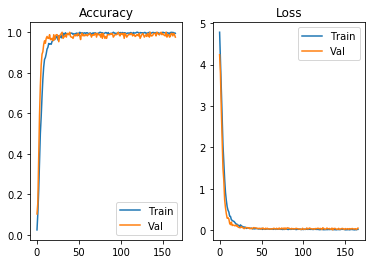

In [66]:
plt.subplot(1, 2, 1)
plt.plot(train_history1.history['acc'], label='Train')
plt.plot(train_history1.history['val_acc'], label='Val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_history1.history['loss'], label='Train')
plt.plot(train_history1.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()

## Prediction

In [67]:
model = load_model('NN_v5.model')

In [68]:
test_df = pd.read_csv('datasets/test.csv')
test_id = test_df.pop('id')
test_numerical = numerical_scaler.transform(test_df)

In [69]:
prediction = model.predict([test_img, test_numerical])

In [70]:
submission = pd.DataFrame(prediction, index=test_id, columns=species_encoder.classes_)

In [71]:
submission.to_csv('submission.csv')